**This notebook shows how to localize with PixLoc, visualize different quantities, and generate interactive animations.**

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import HTML

from pixloc.settings import DATA_PATH, LOC_PATH
from pixloc.localization import RetrievalLocalizer, SimpleTracker
from pixloc.pixlib.geometry import Camera, Pose
from pixloc.visualization.viz_2d import (
    plot_images, plot_keypoints, add_text, features_to_RGB)
from pixloc.visualization.animation import (
    subsample_steps, VideoWriter, create_viz_dump, display_video)

In [2]:

from pprint import pformat

dataset = 'Cambridge'

if dataset == 'Aachen':
    from pixloc.run_Aachen import default_paths, default_confs
elif dataset == 'Cambridge':
    from pixloc.run_Cambridge import default_paths, default_confs
    default_paths = default_paths.interpolate(scene='ShopFacade')
    

print(f'default paths:\n{pformat(default_paths.asdict())}')
paths = default_paths.add_prefixes(DATA_PATH / dataset, LOC_PATH / dataset)

conf = default_confs['from_retrieval']
conf['refinement']['do_pose_approximation'] = False
print(f'conf:\n{pformat(conf)}')

localizer = RetrievalLocalizer(paths, conf)

[12/08/2023 19:43:01 pixloc.localization.model3d INFO] Reading COLMAP model /qianchunhai/hloc/workspace/pixloc/outputs/hloc/Cambridge/ShopFacade/sfm_superpoint+superglue.


default paths:
{'dataset': None,
 'dumps': None,
 'global_descriptors': None,
 'ground_truth': PosixPath('CambridgeLandmarks_Colmap_Retriangulated_1024px/ShopFacade'),
 'hloc_logs': None,
 'query_images': PosixPath('ShopFacade'),
 'query_list': PosixPath('ShopFacade/query_list_with_intrinsics.txt'),
 'reference_images': PosixPath('ShopFacade'),
 'reference_sfm': PosixPath('ShopFacade/sfm_superpoint+superglue'),
 'results': PosixPath('pixloc_Cambridge_ShopFacade.txt'),
 'retrieval_pairs': PosixPath('ShopFacade/pairs-query-netvlad10.txt')}
conf:
{'experiment': 'pixloc_megadepth',
 'features': {},
 'optimizer': {'num_iters': 100, 'pad': 2},
 'refinement': {'average_observations': True,
                'do_pose_approximation': False,
                'filter_covisibility': False,
                'multiscale': [4, 1],
                'normalize_descriptors': True,
                'num_dbs': 5,
                'point_selection': 'all'}}


[12/08/2023 19:43:02 pixloc.utils.io INFO] Imported 103 images from query_list_with_intrinsics.txt
[12/08/2023 19:43:02 pixloc.pixlib.utils.experiments INFO] Loading checkpoint checkpoint_best.tar
/opt/conda/envs/pixloc/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pixloc/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Localize one query

In [3]:
name_q = np.random.choice(list(localizer.queries))  # pick a random query
# name_q = 'query/night/nexus5x/IMG_20161227_192220.jpg' # or select one for Aachen

tracker = SimpleTracker(localizer.refiner)  # will hook & store the predictions
cam_q = Camera.from_colmap(localizer.queries[name_q])
ret = localizer.run_query(name_q, cam_q)

# Visualize the CNN predictions

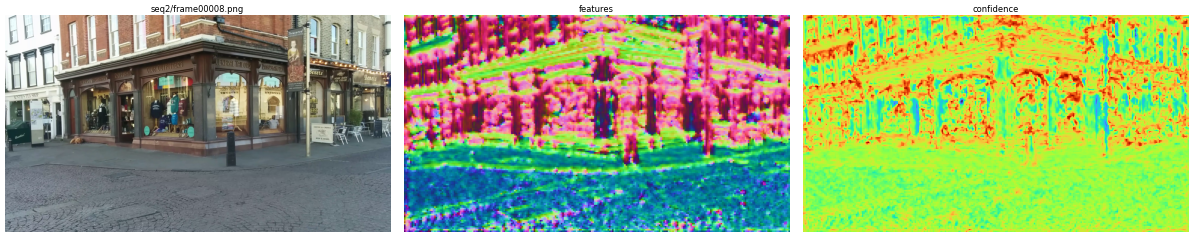

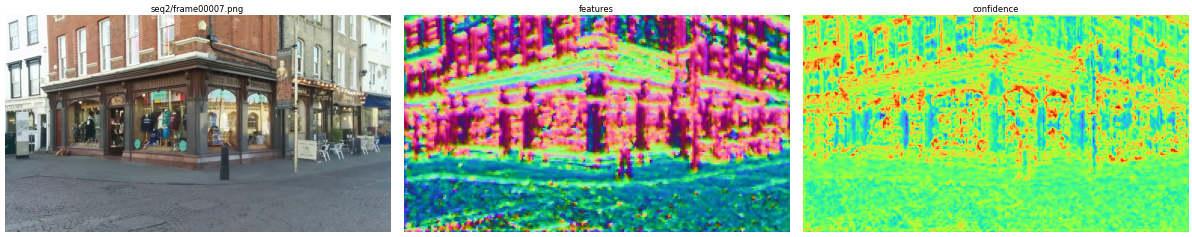

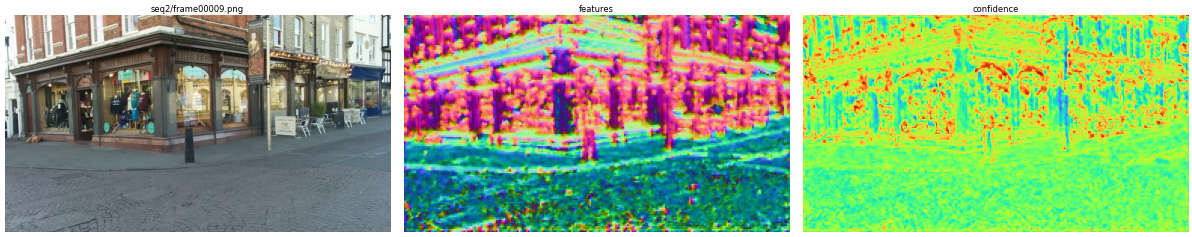

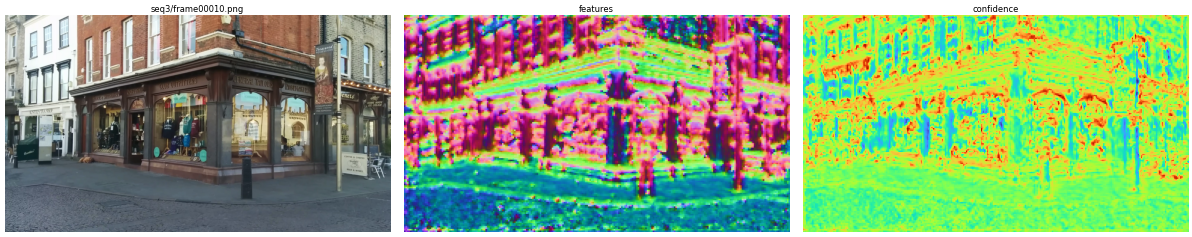

In [4]:
ref_ids = ret['dbids'][:3]  # show 3 references at most
names_r = [localizer.model3d.dbs[i].name for i in ref_ids]
for name in names_r + [name_q]:
    image, features, weights = tracker.dense[name][1]
    features = features_to_RGB(features[1].numpy())[0]
    plot_images([image, features, weights[1]], cmaps='turbo',
                titles=[name, 'features', 'confidence'], dpi=50)

# Visualize the initial and final poses

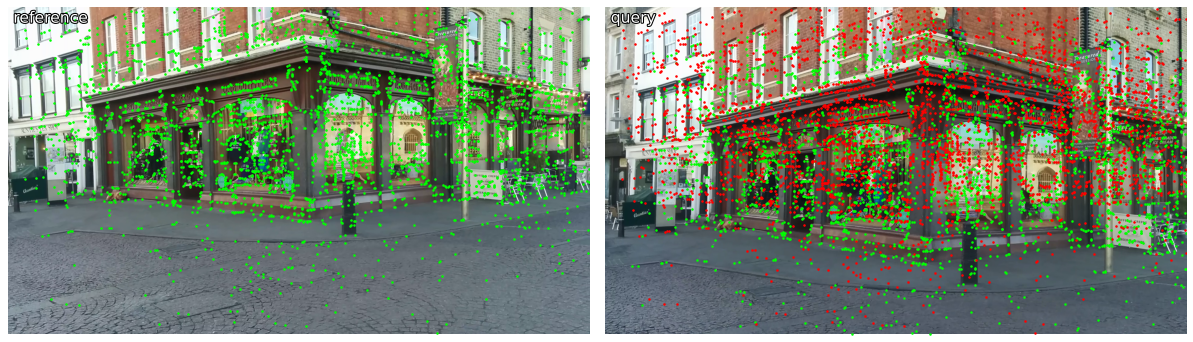

In [5]:
# Pick the first reference image for visualization
ref_id = ref_ids[0]
name_r = names_r[0]
ref = localizer.model3d.dbs[ref_id]
cam_r = Camera.from_colmap(localizer.model3d.cameras[ref.camera_id])
T_w2r = Pose.from_colmap(ref)

image_r = tracker.dense[name_r][1][0]
image_q = tracker.dense[name_q][1][0]
p3d = tracker.p3d
T_w2q_init = tracker.T[0]
T_w2q_final = tracker.T[-1]

# Project the 3D points
p2d_r, mask_r = cam_r.world2image(T_w2r * p3d)
p2d_f, mask_f = cam_q.world2image(T_w2q_final * p3d)
p2d_i, mask_i = cam_q.world2image(T_w2q_init * p3d)

plot_images([image_r, image_q], dpi=75)
plot_keypoints([p2d_r[mask_r], p2d_f[mask_f]], 'lime')
plot_keypoints([None, p2d_i[mask_i]], 'red')
add_text(0, 'reference')
add_text(1, 'query')

# Plot the cost throughout the iterations

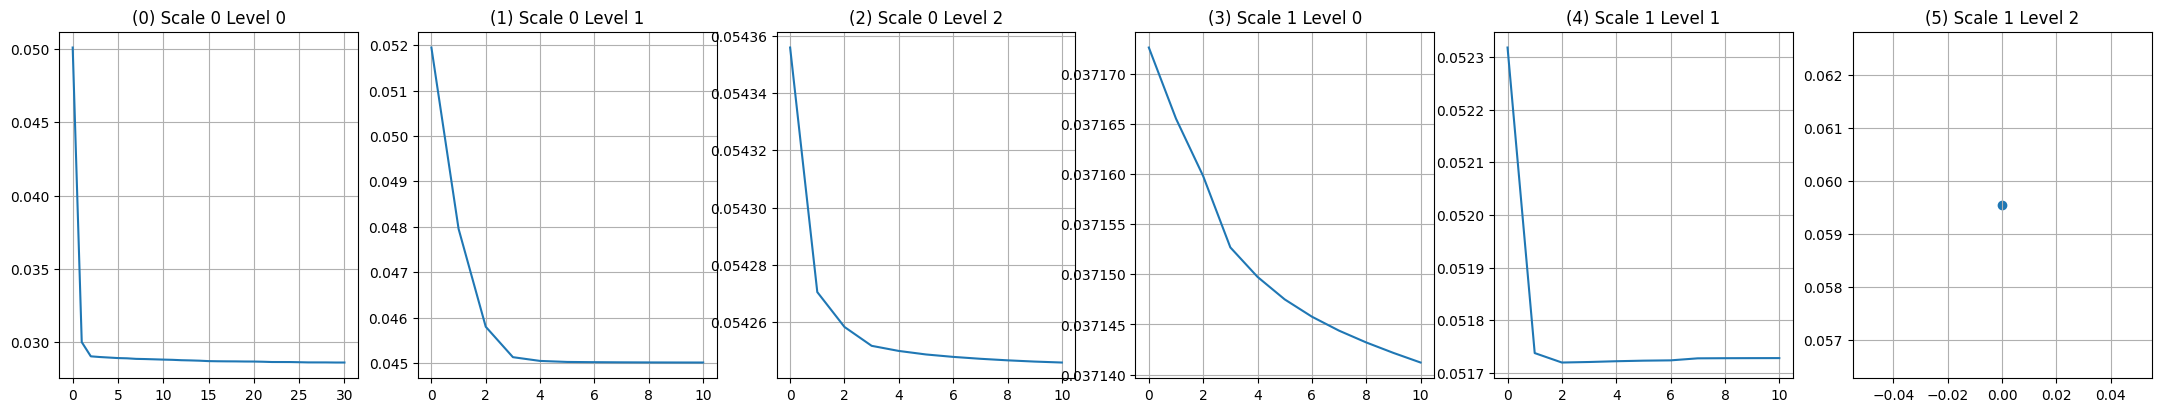

In [6]:
costs = tracker.costs
fig, axes = plt.subplots(1, len(costs), figsize=(len(costs) * 4.5, 4.5))
for i, (ax, cost) in enumerate(zip(axes, costs)):
    ax.plot(cost) if len(cost) > 1 else ax.scatter(0., cost)
    ax.set_title(f'({i}) Scale {i // 3} Level {i % 3}')
    ax.grid()

# Generate a video

In [7]:
T_w2q_all = torch.stack(tracker.T)
p2d_q_all, mask_q_all = cam_q.world2image(T_w2q_all * p3d)
keep = subsample_steps(T_w2q_all, p2d_q_all, mask_q_all, cam_q.size.numpy())
print(f'Keep {len(keep)}/{len(p2d_q_all)} optimization steps for visualization.')

/tmp/ipykernel_51047/282232336.py:1: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1675740251786/work/torch/csrc/utils/python_arg_parser.cpp:350.)
  T_w2q_all = torch.stack(tracker.T)


Keep 12/82 optimization steps for visualization.


In [8]:
video = 'pixloc.mp4'
writer = VideoWriter('./tmp')
for i in tqdm(keep):
    plot_images([image_r, image_q], dpi=100, autoscale=False)
    plot_keypoints([p2d_r[mask_r], p2d_q_all[-1][mask_q_all[-1]]], 'lime')
    plot_keypoints([None, p2d_q_all[i][mask_q_all[i]]], 'red')
    add_text(0, 'reference')
    add_text(1, 'query')
    writer.add_frame()
writer.to_video(video, duration=4, crf=23)  # in seconds

display_video(video)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:15<00:00,  1.25s/it]
[12/08/2023 19:45:32 pixloc.visualization.animation INFO] Running ffmpeg.


# Visualize in 3D!

In [14]:
# the path relative to the viewer folder
viewer = Path('../viewer')
assets = viewer / 'dumps/sample'

# set the Y axis up for threejs
tfm = np.eye(3)
if dataset == 'CMU':
    tfm = np.array([[1, 0, 0], [0, 0, 1], [0, -1, 0]])
elif dataset == '7Scenes':
    tfm = np.diag([1, -1, -1])

# Write a json dump to viewer/assets/sample.json
create_viz_dump(
    assets, paths, cam_q, name_q, T_w2q_all[keep],
    mask_q_all[keep], p2d_q_all[keep],
    ref_ids, localizer.model3d, tracker.p3d_ids, tfm=tfm)

with open(viewer / 'jupyter.html', 'r') as f:
    html = f.read()
html = html.replace('{__path__}', str(viewer))
html = html.replace('{__assets__}', str(assets.parent))
html = html.replace('{__height__}', '600px')
HTML(html)

# Get Mesh

In [13]:
import pixloc.getMesher as mesh

# 图像路径
image_path=Path('../datasets/' + dataset + '/ShopFacade/')
# 输出路径
output_path=Path('../outputs/hloc/' + dataset + '/ShopFacade/')

# 分别导出稀疏点云的txt文件和ply文件
mesh.bin2_txt(output_path)
mesh.bin2_ply(output_path)

# 图片最大尺寸
max_image_size=8000
# 立体匹配的窗口的大小
window_radius=5
# 最低NCC阈值
filter_min_ncc=0.1

# 图像畸变矫正
mesh.undistorter(image_path,output_path,max_image_size)
# 立体块匹配
mesh.patch_match_stereo(output_path,max_image_size,window_radius,filter_min_ncc)
# 点云融合
mesh.stereo_fusion(output_path)
# 分别用泊松重建和Delaunay三角化来进行表面重建并导出ply文件
mesh.poisson_mesher(output_path)
mesh.dulaunay_mesher(output_path)

ModuleNotFoundError: No module named 'pixloc.getMesher'